# Example Use of the `DeleteParticle` Kernel

This notebook shows how the `moacean_parcels.kernels.DeleteParticle` kernel
can be used in `ParticleSet.execute()` as a custom recovery kernel that
deletes any particles that cause kernel errors.

This notebook is based on one created by Birgit Rogalla to explore the
possible fate of material released on to the ocean surface from the
MV Zim Kingston as it burned on 24-Oct-2021.
Fortunately,
there was no significant release of material from the Zim Kingston,
so the particle tracks calculated here are just another demonstration
of the strong ebb/flood currents along the coastline near Victoria.

In [1]:
from datetime import timedelta
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.cm
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4_3D, ErrorCode
import xarray as xr

from moacean_parcels.kernels import DeleteParticle

%matplotlib inline

Set up SalishSeaCast ocean model fields,
and geo-reference arrays from the model mesh mask,
then create a `parcels.FieldSet` from them:

In [2]:
nowcast = Path("/results/SalishSea/nowcast-blue.201905/24oct21/")
forecast = Path("/results/SalishSea/forecast.201905/24oct21/")

nowcastU = nowcast / "SalishSea_1h_20211024_20211024_grid_U.nc"
nowcastV = nowcast / "SalishSea_1h_20211024_20211024_grid_V.nc"
nowcastW = nowcast / "SalishSea_1h_20211024_20211024_grid_W.nc"

forecastU = forecast / "SalishSea_1h_20211025_20211026_grid_U.nc"
forecastV = forecast / "SalishSea_1h_20211025_20211026_grid_V.nc"
forecastW = forecast / "SalishSea_1h_20211025_20211026_grid_W.nc"

files_U = [nowcastU, forecastU]
files_V = [nowcastV, forecastV]
files_W = [nowcastW, forecastW]

mesh_mask = Path("/media/doug/warehouse/MEOPAR/grid/mesh_mask201702.nc")


The `VisibleDeprecationWarning` messages in the output of this cell are a known issue
that will perhaps be resolved in the next release of OceanParcels.

In [3]:
filenames = {
    "U": {"lon": mesh_mask, "lat": mesh_mask, "depth": files_W[0], "data": files_U},
    "V": {"lon": mesh_mask, "lat": mesh_mask, "depth": files_W[0], "data": files_V},
    "W": {"lon": mesh_mask, "lat": mesh_mask, "depth": files_W[0], "data": files_W},
}

dimensions = {
    "U": {"lon": "glamf", "lat": "gphif", "depth": "depthw", "time": "time_counter"},
    "V": {"lon": "glamf", "lat": "gphif", "depth": "depthw", "time": "time_counter"},
    "W": {"lon": "glamf", "lat": "gphif", "depth": "depthw", "time": "time_counter"},
}

variables = {"U": "vozocrtx", "V": "vomecrty", "W": "vovecrtz"}

fieldset = FieldSet.from_nemo(filenames, variables, dimensions)


/media/doug/warehouse/conda_envs/moacean-parcels/lib/python3.9/site-packages/parcels/field.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  timeslices = np.array(timeslices)
/media/doug/warehouse/conda_envs/moacean-parcels/lib/python3.9/site-packages/parcels/field.py:243: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataFiles = np.concatenate(np.array(dataFiles))
/media/doug/warehouse/conda_envs/moacean-parcels/lib/python3.9/site-packages/parcels/field.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is

Set up a collection of particles to be released at the ship's AIS reported location
and release the particles at 1 hour intervals.

In [4]:
release_lon = -123.36337  # east
release_lat = 48.33805  # north
release_depth = 1  # metres

pset = ParticleSet.from_list(
    fieldset=fieldset,  # the fields on which the particles are advected
    pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
    lon=release_lon,  # a vector of release longitudes
    lat=release_lat,  # a vector of release latitudes
    depth=release_depth,  # a vector of release depths
    repeatdt=timedelta(hours=1),  # repeat release of particles every hour
)


In [5]:
kernels = pset.Kernel(AdvectionRK4_3D)

recovery_kernels = {ErrorCode.ErrorOutOfBounds: DeleteParticle}

output_file = pset.ParticleFile(
    name="/tmp/NEMO3D_fire_RK43D.nc", outputdt=timedelta(hours=1)
)


Execute the particles simulation and save the output file.

Notice the messages like:

    Particle [7] lost!! (lon, lat: -123.26292897202094, 48.37882576325017, depth: 4.015960466473189, time: 39600.0s)

in the cell output.
Those are from the `DeleteParticle` recovery kernel doing its job.

Without `recovery=recovery_kernels` in the `.execute()` call,
the simulation would stop when particle 7 goes out of bounds through the surface,
and no output file would be produced.

In [6]:
pset.execute(
    kernels,
    runtime=timedelta(hours=40),  # duration of particles simulation
    dt=timedelta(hours=1),  # particles simulation time step
    recovery=recovery_kernels,
    output_file=output_file,
)

output_file.export()


INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /tmp/parcels-1000/lib49a737f4d032488557d7f6ad96f65175_0.so
INFO: Temporary output files are stored in /tmp/out-ULAGARIP.
INFO: You can use "parcels_convert_npydir_to_netcdf /tmp/out-ULAGARIP" to convert these to a NetCDF file during the run.
 27% (39600.0 of 144000.0) |###          | Elapsed Time: 0:00:33 ETA:   0:02:04

Particle [7] lost!! (lon, lat: -123.26292897202094, 48.37882576325017, depth: 4.015960466473189, time: 39600.0s)


 30% (43200.0 of 144000.0) |###          | Elapsed Time: 0:00:38 ETA:   0:02:21

Particle [3] lost!! (lon, lat: -123.2525273677497, 48.37970223071624, depth: 14.762369210121506, time: 43200.0s)


 32% (46800.0 of 144000.0) |####         | Elapsed Time: 0:00:43 ETA:   0:02:25

Particle [12] lost!! (lon, lat: -123.33204734557782, 48.35583601088063, depth: 2.9548517280782107, time: 46800.0s)


 35% (50400.0 of 144000.0) |####         | Elapsed Time: 0:00:48 ETA:   0:02:16

Particle [6] lost!! (lon, lat: -123.15848183473733, 48.47756111759809, depth: 53.51842788129579, time: 50400.0s)


 40% (57600.0 of 144000.0) |#####        | Elapsed Time: 0:00:59 ETA:   0:02:03

Particle [4] lost!! (lon, lat: -123.14468251460809, 48.48316094082082, depth: 1.4058619025670396, time: 57600.0s)
Particle [8] lost!! (lon, lat: -123.11958089183733, 48.43985826125179, depth: 5.273367492351099, time: 57600.0s)


 42% (61200.0 of 144000.0) |#####        | Elapsed Time: 0:01:05 ETA:   0:02:04

Particle [5] lost!! (lon, lat: -123.13589383771998, 48.48299015991886, depth: 12.88297560729552, time: 61200.0s)


 65% (93600.0 of 144000.0) |########     | Elapsed Time: 0:01:44 ETA:   0:01:05

Particle [13] lost!! (lon, lat: -123.47211933406058, 48.29754074282731, depth: 7.926310052767803, time: 93600.0s)


 67% (97200.0 of 144000.0) |########     | Elapsed Time: 0:01:49 ETA:   0:01:10

Particle [17] lost!! (lon, lat: -123.47956585671241, 48.29225104874882, depth: 4.024776245138128, time: 97200.0s)


 70% (100800.0 of 144000.0) |########    | Elapsed Time: 0:01:56 ETA:   0:01:12

Particle [0] lost!! (lon, lat: -123.14912970742583, 48.452954980847544, depth: 21.58061466377694, time: 100800.0s)
Particle [1] lost!! (lon, lat: -123.14912970742583, 48.452954980847544, depth: 21.58061466377694, time: 100800.0s)
Particle [18] lost!! (lon, lat: -123.53270965389399, 48.29803571034548, depth: 10.141196306154598, time: 100800.0s)


 72% (104400.0 of 144000.0) |########    | Elapsed Time: 0:02:01 ETA:   0:00:56

Particle [22] lost!! (lon, lat: -123.48151894316764, 48.35280690805819, depth: 3.278420927177649, time: 104400.0s)


 75% (108000.0 of 144000.0) |#########   | Elapsed Time: 0:02:05 ETA:   0:00:47

Particle [24] lost!! (lon, lat: -123.50796832025296, 48.32143854696556, depth: 1.7636030350113288, time: 108000.0s)


 77% (111600.0 of 144000.0) |#########   | Elapsed Time: 0:02:11 ETA:   0:00:48

Particle [11] lost!! (lon, lat: -123.52292639751084, 48.31817624325199, depth: 3.9794909236443345, time: 111600.0s)
Particle [21] lost!! (lon, lat: -123.52667460833842, 48.316025800916854, depth: 3.5541201288433513, time: 111600.0s)
Particle [23] lost!! (lon, lat: -123.51800953561721, 48.2982119628578, depth: -1.7027146872569574, time: 111600.0s)
Particle [25] lost!! (lon, lat: -123.51585717591021, 48.293119725350664, depth: -1.1635998159581504, time: 111600.0s)


 95% (136800.0 of 144000.0) |########### | Elapsed Time: 0:02:43 ETA:   0:00:08

Particle [30] lost!! (lon, lat: -123.18812986382724, 48.4204735240998, depth: 5.0363781721680425, time: 136800.0s)


 97% (140400.0 of 144000.0) |########### | Elapsed Time: 0:02:48 ETA:   0:00:05

Particle [27] lost!! (lon, lat: -123.1567717104626, 48.44724911699148, depth: 24.865415518230293, time: 140400.0s)
Particle [32] lost!! (lon, lat: -123.1565265097133, 48.471734766433364, depth: 62.17914843271137, time: 140400.0s)


100% (144000.0 of 144000.0) |############| Elapsed Time: 0:02:49 Time:  0:02:49
/media/doug/warehouse/conda_envs/moacean-parcels/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


Visualize the particle tracks coloured by particle release time

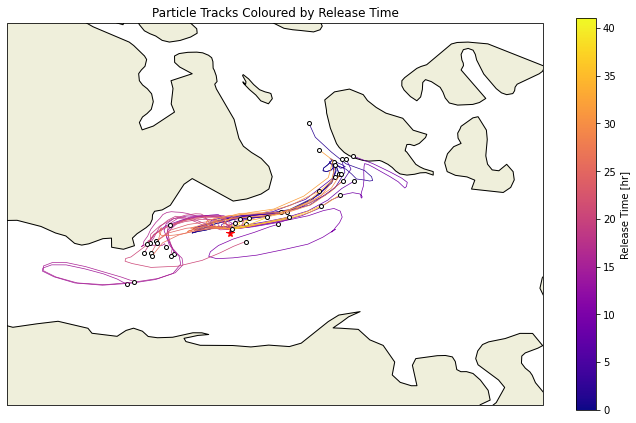

In [12]:
# Figure and axes set-up
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_title("Particle Tracks Coloured by Release Time")
ax.set_extent((-123.8, -122.75, 48, 48.75))
ax.coastlines(resolution="10m", color="black", linewidth=1)
ax.add_feature(cartopy.feature.LAND)

# Mark location of particles release
ax.plot(release_lon, release_lat, marker="*", color="red", markersize=8, transform=ccrs.Geodetic())

with xr.open_dataset(output_file.name) as ds:
    # Colour-map-based collection of colours to show particle release times
    traj_hrs = len(ds.trajectory.traj)
    cmap = matplotlib.cm.plasma
    cmap_norm = matplotlib.colors.Normalize(0, traj_hrs)
    colours_time = cmap(np.linspace(0, 1, traj_hrs))

    for particle in range(traj_hrs):
        # Particle track
        ax.plot(
            ds.lon[particle],
            ds.lat[particle],
            linestyle="-",
            linewidth=0.7,
            color=colours_time[particle],
            transform=ccrs.Geodetic(),
        )
        # Last location on particle track
        # May be end of simulations, but may also be when particle went out of bounds
        last_obs = (
            len(ds.trajectory[particle][np.isfinite(ds.trajectory[particle])]) - 1
        )
        ax.plot(
            ds.lon[particle][last_obs],
            ds.lat[particle][last_obs],
            marker=".",
            color="white",
            markersize=8,
            markeredgecolor="black",
            transform=ccrs.Geodetic(),
        )

    # Colour Bar
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(cmap_norm, cmap),
        ax=ax,
        shrink=0.9,
        label="Release Time [hr]",
    )
